In [1]:
import numpy as np
from scipy import stats
from numpy import nan
import pandas as pd
import s3fs
import xgboost as xgb
from xgboost import XGBClassifier
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from datetime import date, timedelta, datetime
from typing import List, Set, Dict, Tuple, Optional, Iterable, Callable
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, plot_precision_recall_curve, plot_roc_curve
import statistics
from matplotlib import pyplot as plt
import multiprocessing
from sf import sf_connection
import logging
import snowflake.connector
import pyarrow
from snowflake.sqlalchemy import URL
from sqlalchemy import create_engine
import boto3
import warnings
import pyarrow.parquet as pq
import s3fs
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, auc, average_precision_score
import statsmodels.api as sm
import pickle
import shap


In [2]:
pd.options.display.float_format = '{:20,.3f}'.format
pd.options.display.max_columns = None
pd.options.display.max_rows = None
s3 = s3fs.S3FileSystem()
warnings.filterwarnings('ignore')

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>")) # wide notebook display
%matplotlib inline

In [4]:
conn = sf_connection()

### Let's read in the features we created

In [5]:
feature_path = 's3://aap-aiexpzone-nonpii-mktg-general-results-prod/DiscountPreference/test/score/yes_ecomm.parquet'

In [6]:
feature_table = pq.ParquetDataset(feature_path, filesystem=s3).read_pandas().to_pandas()

### Now we read in the label data

In [7]:
label_path = 's3://aap-aiexpzone-nonpii-mktg-general-results-prod/DiscountPreference/test/discount_lables.csv'

In [8]:
label_table = pd.read_csv(label_path, header=0)

In [9]:
label_table.drop(columns={'zero'}, inplace=True)

In [10]:
len(feature_table.drop_duplicates('INDV_ID')), len(label_table.drop_duplicates('INDV_ID'))

(22529095, 22327757)

### Now we inner join on INDV_ID

In [11]:
combined_table = pd.merge(feature_table, label_table, on='INDV_ID', how='inner')

In [12]:
len(combined_table)

22325083

In [13]:
combined_table.drop_duplicates('INDV_ID', inplace=True)

In [14]:
len(combined_table)

22325083

## We now create three more features

In [15]:
combined_table['ecomm_frac'] = combined_table['numEcom']/combined_table['numPurchase']

In [16]:
combined_table['is_sp'] = combined_table['LOYALTY_NUMBER'].apply(lambda x: 1 if x > 0 else 0)

In [17]:
combined_table['is_ecomm'] = combined_table['ecomm_frac'].apply(lambda x: 1 if x > 0.0 else 0)

### Only model customers with ecommerce engagement  - we will predict customers without eComm engatement as 'not discount sensitive'

In [18]:
ecomm_table = combined_table[combined_table.is_ecomm==1].copy()

In [19]:
no_ecomm_table = combined_table[combined_table.is_ecomm==0].copy()

### Now we join with dim_store to get the market type

In [20]:
store_query = """select STORE_NUMBER, MARKET_CLASS_CODE from PEDW.LOCATION.DIM_STORE_V"""

In [21]:
store_xref = pd.read_sql(store_query, conn)

In [22]:
len(store_xref)

7625

In [23]:
store_xref = store_xref[store_xref.MARKET_CLASS_CODE != 'UNKNOWN'].copy()

In [24]:
len(store_xref)

6014

In [25]:
store_xref['MARKET_CLASS_CODE'] = store_xref['MARKET_CLASS_CODE'].apply(lambda x: int(x))

In [26]:
store_xref.dtypes

STORE_NUMBER         int64
MARKET_CLASS_CODE    int64
dtype: object

In [27]:
store_xref.rename(columns={'STORE_NUMBER': 'FULLFILLMENT_STORE_NUMBER'}, inplace=True)

### Now let's look at distances to AAP and competitor stores

In [28]:
aap_query = """
    select 
        LOAD_TS, 
        INDV_ID, 
        STORE_NUMBER, 
        DIST, 
        OPENED
    from(
        select 
        LOAD_TS, 
        INDV_ID, 
        STORE_NUMBER,
        DIST,
        OPENED, 
        ROW_NUMBER() over (partition by INDV_ID order by DIST) as ROWNUM
    from PEDW.PUBLIC.CUST_ATTR_STORE_DISTANCE_AAP_PT_V 
    where (INDV_ID, STORE_NUMBER, LOAD_TS) in (select INDV_ID, STORE_NUMBER, max(LOAD_TS) 
                                                from PEDW.PUBLIC.CUST_ATTR_STORE_DISTANCE_AAP_PT_V
                                                group by INDV_ID, STORE_NUMBER) and OPENED = 1
        ) WHERE ROWNUM = 1 
    """

In [29]:
aap_dist = pd.read_sql(aap_query, conn)

In [30]:
len(aap_dist)

119779373

In [31]:
comp_query = """
    select 
        LOAD_TS, 
        INDV_ID, 
        CMP_STORE_NUMBER, 
        DIST, 
        OPENED
    from(
        select 
        LOAD_TS, 
        INDV_ID, 
        CMP_STORE_NUMBER,
        DIST,
        OPENED, 
        ROW_NUMBER() over (partition by INDV_ID order by DIST) as ROWNUM
    from PEDW.PUBLIC.CUST_ATTR_STORE_DISTANCE_CMP_PT_V
    where (INDV_ID, CMP_STORE_NUMBER, LOAD_TS) in (select INDV_ID, CMP_STORE_NUMBER, max(LOAD_TS) 
                                                from PEDW.PUBLIC.CUST_ATTR_STORE_DISTANCE_CMP_PT_V
                                                group by INDV_ID, CMP_STORE_NUMBER) and OPENED = 1
        ) WHERE ROWNUM = 1 
    """

In [32]:
comp_dist = pd.read_sql(comp_query, conn)

In [33]:
len(comp_dist)

121145247

In [34]:
aap_dist = aap_dist[['INDV_ID', 'DIST']].rename(columns={'DIST': 'AAP_DIST'})

In [35]:
comp_dist = comp_dist[['INDV_ID', 'DIST']].rename(columns={'DIST': 'CMP_DIST'})

In [36]:
len(aap_dist), len(aap_dist.drop_duplicates('INDV_ID'))

(119779373, 119779373)

In [37]:
len(comp_dist), len(comp_dist.drop_duplicates('INDV_ID'))

(121145247, 121145247)

### Now let's get the customer lifetime (tenure)

In [38]:
tenure_query = """
    select 
        INDV_ID, 
        datediff(day, INDV_FIRST_TRANSACTION_DATE, '2021-03-01') as TENURE
    from PEDW.PUBLIC.CUST_ATTR_TRXN_INDV_PT_V 
    where (INDV_ID,LOAD_TS) in
        (select INDV_ID, max(LOAD_TS) from PEDW.PUBLIC.CUST_ATTR_TRXN_INDV_PT_V 
        group by INDV_ID)
        """

In [39]:
tenure = pd.read_sql(tenure_query, conn)

In [40]:
tenure.dtypes

INDV_ID    int64
TENURE     int64
dtype: object

In [41]:
tenure.head()

INDV_ID  TENURE
0  591557254    1079
1  297712381    2269
2  572581623    1488
3  591228963    1083
4  298790753    2214

In [89]:
yes_features = [
     'fyGross',
     'numPurchase',
     'Recency',
     'daysSinceLastPurchase',
     'isEmployee',
     'numReturn',
     'meanPurchaseTransaction',
     'pop_est_cy',
     'pop_density_cy',
     'pct_white',
     'age',
     'pct_college',
     'pct_blue_collar',
     'median_household_income',
     'establishments',
     'IGNITIONEMISSIONFUELSYSTEMS',
     'ADVANCECARESERVICES',
     'AIRFILTERS',
     'LIGHTING',
     'HDHVAC&HYDRAULICS',
     'COMMERCIALHANDSPECIALTYTOOLS',
     'IGNITIONEMISSIONAIRINJECTION&O2SENSORS',
     'WINTER&SUMMERSEASONAL',
     'MOTOROIL',
     'HORNSANDSECURITY',
     'COOLINGSYSTEMRADIATORS',
     'GREASE&GEAR',
     'OILFILTERS',
     'APPEARANCECHEMICALS',
     'HDFILTERS',
     'INTERIORACCESSORIES',
     'HDWHEELEND',
     'BRAKESHARDWARE',
     'OIL&GASACCESSORIES',
     'AIRTOOLS&ACCESSORIES',
     'PERFORMANCE&FUNCTIONALCHEMICALS',
     'STORESUPPLIES&FIXTURES',
     'BRAKESHYDRAULICS',
     'HDOTHER',
     'OTHERCORES',
     'COMMERCIALSHOPEQUIPMENTHIGHTICKET',
     'REFERENCE',
     'ENGINEPARTS',
     'TRANSMISSIONFLUID',
     'COMMERCIALBODYREPAIRTOOLS',
     'DRIVELINECLUTCHES',
     'COOLINGSYSTEMPARTS&COMPONENTS',
     'APPEARANCEACCESSORIES',
     'DRIVELINESHAFTS',
     'CLIMATECONTROLELECTRICALSYSTEMS',
     'CLIMATECONTROLHEATING&AIRCONDITIONING',
     'PERFORMANCEPARTS',
     'SEALANTSADHESIVESANDCOMPOUNDS',
     'COMMERCIALBODYHARDWARE',
     'STARTERS&ALTERNATORS',
     'BEARINGSSEALSHUBASSEMBLIES',
     'BRAKESCALIPERS',
     'IGNITIONEMISSIONSPARKPLUGS',
     'EXHAUST',
     'ENGINESANDTRANSMISSIONS',
     'OTHERFILTERS',
     'FLUIDMANAGEMENTACCESSORIES',
     'RIDECONTROL',
     'COOLINGSYSTEMWATERPUMPSANDHARDWARE',
     'COMMERCIALJACKSLIFTS',
     'DORMANINNOVATION',
     'LOANERTOOLS',
     'BATTERYACCESSORIES',
     'UNKNOWN',
     'COMMERCIALAIRTOOLS&ACCESSORIES',
     'POWERSTEERING&COMPONENTS',
     'GENERALMERCHANDBATTERIES',
     'DRIVELINETRANSMISSIONPARTS',
     'PAINT&CHEMICALS',
     'NUTSBOLTSMISCHARDWARE',
     'HAND&SPECIALTYTOOLS',
     'PROTECTIVEGEAR',
     'DORMANUNDERCARUNDERHOOD',
     'AIRFRESHENERS',
     'TESTING&ELECTRICALEQUIPMENT',
     'NONSKUMERCHANDISE',
     'IGNITIONEMISSIONEMISSIONSENSORS&VALVES',
     'CHASSISPARTS',
     'COMMERCIALPAINT&CHEMICALS',
     'IGNITIONEMISSIONWIRE',
     'TOWING&HITCH',
     'TIRES&WHEELSPUERTORICOONLY',
     'SERVICE',
     'TIREREPAIR&ACCESSORIES',
     'ELECTRONICS',
     'JACKSANDLIFTS',
     'CONSUMABLES',
     'DORMANRETAILBODY',
     'IGNITIONEMISSIONIGNITIONCOMPONENTS',
     'DRIVELINEPARTSANDMOUNTS',
     'GASKETS',
     'IGNITIONEMISSIONELECTRICALCOMPONENTS',
     'EXTERNALSUPPLY',
     'BRAKESFRICTIONPADS&SHOES',
     'BODYREPAIR&FUSES',
     'HDCHASSIS',
     'ACCHEMICALS&ACCESSORIES',
     'EXTERIORACCESSORIES',
     'BRAKESDRUMSANDROTORS',
     'IGNITIONEMISSIONFUELINJECTIONCOMPONENTS',
     'WIPERS',
     'BULKCHEMICALSANTIFREEZEANDWASHERSOLVENT',
     'ELECTRICAL',
     'BATTERIES',
     'Revenue',
     'OpenRate',
     'ClickRate',
     'ConversionRate',
     'numSessions',
     'meanHits',
     'meanPages',
     'meanRemovals',
     'meanPurchases',
     'meanAdditions',
     'meanCheckouts',
     'meanAbandoned',
     'meanQuality',
     'meanTime',
     'acura',
     'audi',
     'bmw',
     'bick',
     'cadillac',
     'chevrolet',
     'chrysler',
     'dodge',
     'ford',
     'gmc',
     'harleydavidson',
     'honda',
     'hyundai',
     'infiniti',
     'isuzu',
     'jaguar',
     'jeep',
     'kia',
     'landrover',
     'lexus',
     'lincoln',
     'mazda',
     'mercedesbenz',
     'mercury',
     'mini',
     'mitsubishi',
     'nissan',
     'oldsmobile',
     'plymouth',
     'pontiac',
     'ram',
     'saab',
     'saturn',
     'scion',
     'subaru',
     'suzuki',
     'toyota',
     'volkswagen',
     'volvo',
     'yamaha',
     'maxVehicleAge',
     'ecomm_frac',
     'is_sp',
     'MARKET_CLASS_CODE',
     'AAP_DIST',
     'CMP_DIST',
     'aap_closer_by',
     'comp_dist_ratio',
     'TENURE']

In [90]:
no_features = [
     'fyGross',
     'numPurchase',
     'Recency',
     'daysSinceLastPurchase',
     'isEmployee',
     'numReturn',
     'meanPurchaseTransaction',
     'pop_est_cy',
     'pop_density_cy',
     'pct_white',
     'age',
     'pct_college',
     'pct_blue_collar',
     'median_household_income',
     'establishments',
     'IGNITIONEMISSIONFUELSYSTEMS',
     'ADVANCECARESERVICES',
     'AIRFILTERS',
     'LIGHTING',
     'HDHVAC&HYDRAULICS',
     'COMMERCIALHANDSPECIALTYTOOLS',
     'IGNITIONEMISSIONAIRINJECTION&O2SENSORS',
     'WINTER&SUMMERSEASONAL',
     'MOTOROIL',
     'HORNSANDSECURITY',
     'COOLINGSYSTEMRADIATORS',
     'GREASE&GEAR',
     'OILFILTERS',
     'APPEARANCECHEMICALS',
     'HDFILTERS',
     'INTERIORACCESSORIES',
     'HDWHEELEND',
     'BRAKESHARDWARE',
     'OIL&GASACCESSORIES',
     'AIRTOOLS&ACCESSORIES',
     'PERFORMANCE&FUNCTIONALCHEMICALS',
     'STORESUPPLIES&FIXTURES',
     'BRAKESHYDRAULICS',
     'HDOTHER',
     'OTHERCORES',
     'COMMERCIALSHOPEQUIPMENTHIGHTICKET',
     'REFERENCE',
     'ENGINEPARTS',
     'TRANSMISSIONFLUID',
     'COMMERCIALBODYREPAIRTOOLS',
     'DRIVELINECLUTCHES',
     'COOLINGSYSTEMPARTS&COMPONENTS',
     'APPEARANCEACCESSORIES',
     'DRIVELINESHAFTS',
     'CLIMATECONTROLELECTRICALSYSTEMS',
     'CLIMATECONTROLHEATING&AIRCONDITIONING',
     'PERFORMANCEPARTS',
     'SEALANTSADHESIVESANDCOMPOUNDS',
     'COMMERCIALBODYHARDWARE',
     'STARTERS&ALTERNATORS',
     'BEARINGSSEALSHUBASSEMBLIES',
     'BRAKESCALIPERS',
     'IGNITIONEMISSIONSPARKPLUGS',
     'EXHAUST',
     'ENGINESANDTRANSMISSIONS',
     'OTHERFILTERS',
     'FLUIDMANAGEMENTACCESSORIES',
     'RIDECONTROL',
     'COOLINGSYSTEMWATERPUMPSANDHARDWARE',
     'COMMERCIALJACKSLIFTS',
     'DORMANINNOVATION',
     'LOANERTOOLS',
     'BATTERYACCESSORIES',
     'UNKNOWN',
     'COMMERCIALAIRTOOLS&ACCESSORIES',
     'POWERSTEERING&COMPONENTS',
     'GENERALMERCHANDBATTERIES',
     'DRIVELINETRANSMISSIONPARTS',
     'PAINT&CHEMICALS',
     'NUTSBOLTSMISCHARDWARE',
     'HAND&SPECIALTYTOOLS',
     'PROTECTIVEGEAR',
     'DORMANUNDERCARUNDERHOOD',
     'AIRFRESHENERS',
     'TESTING&ELECTRICALEQUIPMENT',
     'NONSKUMERCHANDISE',
     'IGNITIONEMISSIONEMISSIONSENSORS&VALVES',
     'CHASSISPARTS',
     'COMMERCIALPAINT&CHEMICALS',
     'IGNITIONEMISSIONWIRE',
     'TOWING&HITCH',
     'TIRES&WHEELSPUERTORICOONLY',
     'SERVICE',
     'TIREREPAIR&ACCESSORIES',
     'ELECTRONICS',
     'JACKSANDLIFTS',
     'CONSUMABLES',
     'DORMANRETAILBODY',
     'IGNITIONEMISSIONIGNITIONCOMPONENTS',
     'DRIVELINEPARTSANDMOUNTS',
     'GASKETS',
     'IGNITIONEMISSIONELECTRICALCOMPONENTS',
     'EXTERNALSUPPLY',
     'BRAKESFRICTIONPADS&SHOES',
     'BODYREPAIR&FUSES',
     'HDCHASSIS',
     'ACCHEMICALS&ACCESSORIES',
     'EXTERIORACCESSORIES',
     'BRAKESDRUMSANDROTORS',
     'IGNITIONEMISSIONFUELINJECTIONCOMPONENTS',
     'WIPERS',
     'BULKCHEMICALSANTIFREEZEANDWASHERSOLVENT',
     'ELECTRICAL',
     'BATTERIES',
     'ecomm_frac',
     'is_sp',
     'MARKET_CLASS_CODE',
     'AAP_DIST',
     'CMP_DIST',
     'aap_closer_by',
     'comp_dist_ratio',
     'TENURE']

In [43]:
label = ['3quarter']

In [127]:
def write_pickle_to_s3(bucket, key, data):
    """Function to write pickle files to s3"""
    
    s3 = boto3.client('s3')
    serialized = pickle.dumps(data)
    s3.put_object(Bucket=bucket, Key=key, Body=serialized)
    
    
def read_pickle_from_s3(bucket, key):
    """Function to read pickle files from s3"""
    
    s3 = boto3.client('s3')
    response = s3.get_object(Bucket=bucket, Key=key)
    body = response['Body'].read()
    
    return pickle.loads(body)

### Read the old models

In [45]:
BUCKET = 'aap-aiexpzone-nonpii-mktg-general-results-prod'
ECOMM_KEY = 'DiscountPreference/Models/XGB/xgb.mod'
NO_KEY = 'DiscountPreference/Models/XGB/xgb_no_ecomm.mod'

In [135]:
model_yes = read_pickle_from_s3(BUCKET, ECOMM_KEY)
model_no = read_pickle_from_s3(BUCKET, NO_KEY)

In [143]:
yes_feature_set = set(model_yes.get_booster().feature_names)

In [144]:
no_feature_set = set(model_no.get_booster().feature_names)

In [47]:
type(model_yes), type(model_no)

(xgboost.sklearn.XGBClassifier, xgboost.sklearn.XGBClassifier)

In [48]:
len(combined_table)

22325083

### Now we join our new feature dataframes to the table and fill nas

#### First the market code

In [49]:
combined_table = pd.merge(combined_table, store_xref, how='left', on='FULLFILLMENT_STORE_NUMBER')

In [50]:
combined_table.isnull().sum()

INDV_ID                                         0
fyGross                                         0
2hGross                                         0
4qGross                                         0
fyNet                                           0
2hNet                                           0
4qNet                                           0
numEcom                                         0
numPurchase                                     0
Recency                                         0
daysSinceLastPurchase                           0
isEmployee                                      0
numReturn                                       0
numCoupon                                       0
LOYALTY_NUMBER                                  0
meanPurchaseTransaction                         0
FULLFILLMENT_STORE_NUMBER                       0
pop_est_cy                                      0
pop_density_cy                                  0
pct_white                                       0


#### Fill nulls with 0

In [51]:
combined_table.fillna(0, inplace=True)

#### Now aap store distances

In [52]:
combined_table = pd.merge(combined_table, aap_dist, how='left', on='INDV_ID')

In [53]:
combined_table.isna().sum()

INDV_ID                                          0
fyGross                                          0
2hGross                                          0
4qGross                                          0
fyNet                                            0
2hNet                                            0
4qNet                                            0
numEcom                                          0
numPurchase                                      0
Recency                                          0
daysSinceLastPurchase                            0
isEmployee                                       0
numReturn                                        0
numCoupon                                        0
LOYALTY_NUMBER                                   0
meanPurchaseTransaction                          0
FULLFILLMENT_STORE_NUMBER                        0
pop_est_cy                                       0
pop_density_cy                                   0
pct_white                      

In [54]:
combined_table['AAP_DIST'] = combined_table['AAP_DIST'].fillna(combined_table['AAP_DIST'].mean())

#### Now competitor store distances

In [55]:
combined_table = pd.merge(combined_table, comp_dist, how='left', on='INDV_ID')

In [56]:
combined_table.isna().sum()

INDV_ID                                          0
fyGross                                          0
2hGross                                          0
4qGross                                          0
fyNet                                            0
2hNet                                            0
4qNet                                            0
numEcom                                          0
numPurchase                                      0
Recency                                          0
daysSinceLastPurchase                            0
isEmployee                                       0
numReturn                                        0
numCoupon                                        0
LOYALTY_NUMBER                                   0
meanPurchaseTransaction                          0
FULLFILLMENT_STORE_NUMBER                        0
pop_est_cy                                       0
pop_density_cy                                   0
pct_white                      

In [57]:
combined_table['CMP_DIST'] = combined_table['CMP_DIST'].fillna(combined_table['CMP_DIST'].mean())

In [58]:
combined_table['aap_closer_by'] = combined_table['CMP_DIST'] - combined_table['AAP_DIST']

In [59]:
combined_table['comp_dist_ratio'] = combined_table['CMP_DIST']/combined_table['AAP_DIST']

### Now let's get the customer lifetime (tenure)

In [60]:
combined_table = pd.merge(combined_table, tenure, how='left', on='INDV_ID')

In [61]:
combined_table.isna().sum()

INDV_ID                                    0
fyGross                                    0
2hGross                                    0
4qGross                                    0
fyNet                                      0
2hNet                                      0
4qNet                                      0
numEcom                                    0
numPurchase                                0
Recency                                    0
daysSinceLastPurchase                      0
isEmployee                                 0
numReturn                                  0
numCoupon                                  0
LOYALTY_NUMBER                             0
meanPurchaseTransaction                    0
FULLFILLMENT_STORE_NUMBER                  0
pop_est_cy                                 0
pop_density_cy                             0
pct_white                                  0
age                                        0
pct_college                                0
pct_blue_c

In [62]:
combined_table.loc[(combined_table.TENURE < 1), 'TENURE'] = 1

### We one-hot encode market class

In [64]:
onehot_encoder = OneHotEncoder(sparse=False, categories='auto', dtype=np.int, handle_unknown='ignore')

In [65]:
market_class_feature = onehot_encoder.fit_transform(combined_table[['MARKET_CLASS_CODE']])


In [66]:
market_class_feature.shape

(22325085, 8)

In [67]:
market_categories = [cat for cat in onehot_encoder.categories_[0]]

In [68]:
market_categories

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]

In [69]:
market_categories_dict = {0: 'zero', 
                             1: 'one',
                             2: 'two',
                             3: 'three',
                             4: 'four',
                             5: 'five',
                             6: 'six',
                             7: 'seven'}

In [70]:
market_categories = list(map(market_categories_dict.get, market_categories))

In [71]:
market_class_dataframe = pd.DataFrame(market_class_feature)
market_class_dataframe.columns = market_categories

In [72]:
market_class_dataframe.head()

zero  one  two  three  four  five  six  seven
0     0    0    0      0     0     0    1      0
1     0    0    0      0     0     0    1      0
2     0    0    0      0     0     0    1      0
3     0    0    0      0     0     1    0      0
4     0    0    0      0     0     0    1      0

In [73]:
combined_table.reset_index(drop=True, inplace=True)

In [74]:
len(combined_table), len(market_class_dataframe)

(22325085, 22325085)

In [75]:
combined_table = pd.merge(combined_table, market_class_dataframe, left_index=True, right_index=True)

In [76]:
combined_table.dtypes

INDV_ID                                            object
fyGross                                           float64
2hGross                                           float64
4qGross                                           float64
fyNet                                             float64
2hNet                                             float64
4qNet                                             float64
numEcom                                             int64
numPurchase                                         int64
Recency                                             int32
daysSinceLastPurchase                               int32
isEmployee                                          int32
numReturn                                           int64
numCoupon                                           int64
LOYALTY_NUMBER                                      int64
meanPurchaseTransaction                           float64
FULLFILLMENT_STORE_NUMBER                           int32
pop_est_cy    

In [77]:
combined_table[market_categories + ['MARKET_CLASS_CODE']].head(20)

zero  one  two  three  four  five  six  seven    MARKET_CLASS_CODE
0      0    0    0      0     0     0    1      0                6.000
1      0    0    0      0     0     0    1      0                6.000
2      0    0    0      0     0     0    1      0                6.000
3      0    0    0      0     0     1    0      0                5.000
4      0    0    0      0     0     0    1      0                6.000
5      0    0    0      0     0     0    1      0                6.000
6      0    0    0      0     0     0    1      0                6.000
7      0    0    0      0     0     0    1      0                6.000
8      0    0    0      0     0     0    1      0                6.000
9      0    0    0      0     0     0    1      0                6.000
10     0    0    0      0     0     1    0      0                5.000
11     0    0    0      0     1     0    0      0                4.000
12     0    0    0      1     0     0    0      0                3.000
13     0    0    0      0     0     0    1      0                6.000
14     0    0    0      0     0     0    1      0                6.000
15     0    0    0      0     0     0    1      0                6.000
16     0    0    0      0     0     0    1      0                6.000
17     0    0    0      0     0     0    1      0                6.000
18     0    0    0      0     0     0    0      1                7.000
19     0    0    0      0     0     0    1      0                6.000

In [78]:
combined_table.drop(columns={'MARKET_CLASS_CODE'}, inplace=True)

In [91]:
yes_features = [feature for feature in yes_features if feature != 'MARKET_CLASS_CODE']

In [92]:
no_features = [feature for feature in no_features if feature != 'MARKET_CLASS_CODE']

In [93]:
len(yes_features)

171

In [94]:
len(no_features)

116

In [98]:
yes_table = combined_table[combined_table.is_ecomm==1]

In [101]:
no_table = combined_table[combined_table.is_ecomm==0]

In [102]:
len(yes_table), len(no_table)

(3489566, 18835519)

In [103]:
X_train_yes, X_test_yes, y_train_yes, y_test_yes = train_test_split(yes_table[yes_features], yes_table[label], 
                                                    test_size=0.1, random_state=1, stratify=yes_table[label])

In [132]:
len(X_test_yes)

348957

In [104]:
X_train_no, X_test_no, y_train_no, y_test_no = train_test_split(no_table[no_features], no_table[label], 
                                                    test_size=0.1, random_state=1, stratify=no_table[label])

In [133]:
len(X_test_no)

1883552

In [105]:
hyperparameters_yes = {'colsample_bytree': 0.5893303389034698,
 'gamma': 0.0014510211867202472,
 'learning_rate': 0.153066836047544,
 'max_depth': 9,
 'min_child_weight': 4.190530104261271,
 'reg_alpha': 0.014300489761012614,
 'reg_lambda': 11.957028469530997,
 'subsample': 0.8524779791182526}

In [106]:
hyperparameters_no = {'colsample_bytree': 0.5043261093128858,
 'gamma': 3.66105683732913,
 'learning_rate': 0.3977475883159281,
 'max_depth': 11,
 'min_child_weight': 26.193840962855194,
 'reg_alpha': 37.353837608306776,
 'reg_lambda': 7.884945581258663,
 'subsample': 0.9040759959028901}

### Train and evaluate the yes model

In [108]:
xg_class_yes = xgb.XGBClassifier(**hyperparameters_yes, n_jobs=90, n_estimators=500)

In [110]:
eval_set_yes = [(X_train_yes, y_train_yes)] 
_ = xg_class_yes.fit(X_train_yes, y_train_yes, eval_set=eval_set_yes, eval_metric='auc',
            early_stopping_rounds=10, verbose=True)

[0]	validation_0-auc:0.86692
[1]	validation_0-auc:0.90542
[2]	validation_0-auc:0.90717
[3]	validation_0-auc:0.91346
[4]	validation_0-auc:0.91616
[5]	validation_0-auc:0.91806
[6]	validation_0-auc:0.91947
[7]	validation_0-auc:0.92033
[8]	validation_0-auc:0.92084
[9]	validation_0-auc:0.92083
[10]	validation_0-auc:0.92225
[11]	validation_0-auc:0.92359
[12]	validation_0-auc:0.92494
[13]	validation_0-auc:0.92610
[14]	validation_0-auc:0.92733
[15]	validation_0-auc:0.92783
[16]	validation_0-auc:0.92895
[17]	validation_0-auc:0.92983
[18]	validation_0-auc:0.93069
[19]	validation_0-auc:0.93132
[20]	validation_0-auc:0.93213
[21]	validation_0-auc:0.93239
[22]	validation_0-auc:0.93300
[23]	validation_0-auc:0.93383
[24]	validation_0-auc:0.93446
[25]	validation_0-auc:0.93522
[26]	validation_0-auc:0.93578
[27]	validation_0-auc:0.93610
[28]	validation_0-auc:0.93644
[29]	validation_0-auc:0.93695
[30]	validation_0-auc:0.93740
[31]	validation_0-auc:0.93780
[32]	validation_0-auc:0.93819
[33]	validation_0-au

[268]	validation_0-auc:0.96537
[269]	validation_0-auc:0.96543
[270]	validation_0-auc:0.96554
[271]	validation_0-auc:0.96559
[272]	validation_0-auc:0.96566
[273]	validation_0-auc:0.96572
[274]	validation_0-auc:0.96577
[275]	validation_0-auc:0.96578
[276]	validation_0-auc:0.96583
[277]	validation_0-auc:0.96589
[278]	validation_0-auc:0.96591
[279]	validation_0-auc:0.96593
[280]	validation_0-auc:0.96601
[281]	validation_0-auc:0.96603
[282]	validation_0-auc:0.96607
[283]	validation_0-auc:0.96609
[284]	validation_0-auc:0.96617
[285]	validation_0-auc:0.96622
[286]	validation_0-auc:0.96620
[287]	validation_0-auc:0.96625
[288]	validation_0-auc:0.96629
[289]	validation_0-auc:0.96630
[290]	validation_0-auc:0.96639
[291]	validation_0-auc:0.96645
[292]	validation_0-auc:0.96652
[293]	validation_0-auc:0.96655
[294]	validation_0-auc:0.96655
[295]	validation_0-auc:0.96662
[296]	validation_0-auc:0.96669
[297]	validation_0-auc:0.96671
[298]	validation_0-auc:0.96672
[299]	validation_0-auc:0.96679
[300]	va

In [111]:
test_pred_yes = xg_class_yes.predict(X_test_yes)

In [112]:
test_score_yes = xg_class_yes.predict_proba(X_test_yes)

In [113]:
test_score_unpacked_yes = [score[1] for score in test_score_yes]

In [114]:
confusion_matrix(y_test_yes, test_pred_yes)

array([[140385,  25514],
       [ 12711, 170347]])

In [115]:
print(classification_report(y_test_yes, test_pred_yes))

              precision    recall  f1-score   support

           0       0.92      0.85      0.88    165899
           1       0.87      0.93      0.90    183058

    accuracy                           0.89    348957
   macro avg       0.89      0.89      0.89    348957
weighted avg       0.89      0.89      0.89    348957



In [116]:
roc_auc_score(y_test_yes,test_score_unpacked_yes)

0.9517656312169166

In [117]:
average_precision_score(y_test_yes, test_score_unpacked_yes, pos_label=1)

0.9528918997023346

In [ ]:
s

### Now we train and evaluate the no model

In [109]:
xg_class_no = xgb.XGBClassifier(**hyperparameters_no, n_jobs=90, n_estimators=500)

In [119]:
eval_set_no = [(X_train_no, y_train_no)] 
_ = xg_class_no.fit(X_train_no, y_train_no, eval_set=eval_set_no, eval_metric='auc',
            early_stopping_rounds=10, verbose=True)

[0]	validation_0-auc:0.72388
[1]	validation_0-auc:0.72469
[2]	validation_0-auc:0.74875
[3]	validation_0-auc:0.75655
[4]	validation_0-auc:0.76377
[5]	validation_0-auc:0.76380
[6]	validation_0-auc:0.77248
[7]	validation_0-auc:0.77917
[8]	validation_0-auc:0.78592
[9]	validation_0-auc:0.79261
[10]	validation_0-auc:0.80413
[11]	validation_0-auc:0.80747
[12]	validation_0-auc:0.80965
[13]	validation_0-auc:0.81447
[14]	validation_0-auc:0.81558
[15]	validation_0-auc:0.81934
[16]	validation_0-auc:0.82151
[17]	validation_0-auc:0.82526
[18]	validation_0-auc:0.82777
[19]	validation_0-auc:0.82904
[20]	validation_0-auc:0.82953
[21]	validation_0-auc:0.83377
[22]	validation_0-auc:0.83455
[23]	validation_0-auc:0.83716
[24]	validation_0-auc:0.83900
[25]	validation_0-auc:0.83932
[26]	validation_0-auc:0.83999
[27]	validation_0-auc:0.84084
[28]	validation_0-auc:0.84239
[29]	validation_0-auc:0.84504
[30]	validation_0-auc:0.84641
[31]	validation_0-auc:0.84656
[32]	validation_0-auc:0.84703
[33]	validation_0-au

[268]	validation_0-auc:0.90413
[269]	validation_0-auc:0.90421
[270]	validation_0-auc:0.90432
[271]	validation_0-auc:0.90431
[272]	validation_0-auc:0.90438
[273]	validation_0-auc:0.90448
[274]	validation_0-auc:0.90450
[275]	validation_0-auc:0.90455
[276]	validation_0-auc:0.90459
[277]	validation_0-auc:0.90462
[278]	validation_0-auc:0.90470
[279]	validation_0-auc:0.90479
[280]	validation_0-auc:0.90482
[281]	validation_0-auc:0.90486
[282]	validation_0-auc:0.90495
[283]	validation_0-auc:0.90498
[284]	validation_0-auc:0.90514
[285]	validation_0-auc:0.90514
[286]	validation_0-auc:0.90523
[287]	validation_0-auc:0.90540
[288]	validation_0-auc:0.90543
[289]	validation_0-auc:0.90547
[290]	validation_0-auc:0.90553
[291]	validation_0-auc:0.90555
[292]	validation_0-auc:0.90560
[293]	validation_0-auc:0.90563
[294]	validation_0-auc:0.90566
[295]	validation_0-auc:0.90575
[296]	validation_0-auc:0.90572
[297]	validation_0-auc:0.90578
[298]	validation_0-auc:0.90591
[299]	validation_0-auc:0.90592
[300]	va

In [120]:
test_pred_no = xg_class_no.predict(X_test_no)

In [121]:
test_score_no = xg_class_no.predict_proba(X_test_no)

In [122]:
test_score_unpacked_no = [score[1] for score in test_score_no]

In [123]:
confusion_matrix(y_test_no, test_pred_no)

array([[1765267,    6829],
       [  77783,   33673]])

In [124]:
print(classification_report(y_test_no, test_pred_no))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98   1772096
           1       0.83      0.30      0.44    111456

    accuracy                           0.96   1883552
   macro avg       0.89      0.65      0.71   1883552
weighted avg       0.95      0.96      0.95   1883552



In [125]:
roc_auc_score(y_test_no,test_score_unpacked_no)

0.8773172007130177

In [126]:
average_precision_score(y_test_no, test_score_unpacked_no, pos_label=1)

0.5461846217293889

In [146]:
yes_feature_set - set(yes_features)

{'Sends', 'TOTAL'}

In [147]:
no_feature_set - set(no_features)

{'ClickRate',
 'ConversionRate',
 'OpenRate',
 'Revenue',
 'Sends',
 'TOTAL',
 'acura',
 'audi',
 'bick',
 'bmw',
 'cadillac',
 'chevrolet',
 'chrysler',
 'dodge',
 'ford',
 'gmc',
 'harleydavidson',
 'honda',
 'hyundai',
 'infiniti',
 'isuzu',
 'jaguar',
 'jeep',
 'kia',
 'landrover',
 'lexus',
 'lincoln',
 'maxVehicleAge',
 'mazda',
 'meanAbandoned',
 'meanAdditions',
 'meanCheckouts',
 'meanHits',
 'meanPages',
 'meanPurchases',
 'meanQuality',
 'meanRemovals',
 'meanTime',
 'mercedesbenz',
 'mercury',
 'mini',
 'mitsubishi',
 'nissan',
 'numSessions',
 'oldsmobile',
 'plymouth',
 'pontiac',
 'ram',
 'saab',
 'saturn',
 'scion',
 'subaru',
 'suzuki',
 'toyota',
 'volkswagen',
 'volvo',
 'yamaha'}

### Write the new models

In [148]:
BUCKET = 'aap-aiexpzone-nonpii-mktg-general-results-prod'
YES_KEY = 'DiscountPreference/Models/XGB/xg_class_yes-5-3.mod'
NO_KEY = 'DiscountPreference/Models/XGB/xg_class_no-5-3.mod'

In [149]:
help(write_pickle_to_s3)

Help on function write_pickle_to_s3 in module __main__:

write_pickle_to_s3(bucket, key, data)
    Function to write pickle files to s3



In [150]:
write_pickle_to_s3(BUCKET, YES_KEY, xg_class_yes)

In [151]:
write_pickle_to_s3(BUCKET, NO_KEY, xg_class_no)

# Now we try SHAP for eCommerce engaged customers

In [152]:
explainerXGB_yes = shap.TreeExplainer(xg_class_yes)

In [275]:
expected_value = explainerXGB_yes.expected_value

In [153]:
shap_values_XGB_test_yes = explainerXGB_yes.shap_values(X_test_yes)

In [188]:
j=13

shap.initjs()

In [189]:
shap.force_plot(explainerXGB_yes.expected_value, shap_values_XGB_test_yes[j], X_test_yes.iloc[[j]], link='logit')

In [212]:
np.array(y_test_yes).squeeze().shape

(348957,)

In [211]:
test_pred_yes.shape

(348957,)

In [225]:
len(test_score_unpacked_yes)

348957

In [223]:
np.where(np.array(y_test_yes).squeeze() == test_pred_yes)[0]

array([     0,      2,      3, ..., 348954, 348955, 348956])

### We now collect lists of indexes for diffeerent catgories

In [226]:
true_positive_indicies = np.where((np.array(y_test_yes).squeeze()==1) & (test_pred_yes==1))

In [231]:
true_negative_indicies = np.where((np.array(y_test_yes).squeeze()==0) & (test_pred_yes==0))

In [233]:
false_positive_indicies = np.where((np.array(y_test_yes).squeeze()==0) & (test_pred_yes==1))

In [235]:
false_negative_indicies = np.where((np.array(y_test_yes).squeeze()==1) & (test_pred_yes==0))

In [419]:
middling_indices = np.where((np.array(test_score_unpacked_yes) < .6) & (np.array(test_score_unpacked_yes) > .4))

In [436]:
high_indices = np.where((np.array(test_score_unpacked_yes) < 1.0) & (np.array(test_score_unpacked_yes) > .9))

In [421]:
low_indices = np.where((np.array(test_score_unpacked_yes) < .4) & (np.array(test_score_unpacked_yes) > 0.0))

In [272]:
true_positive_X_test_yes = X_test_yes.iloc[list(true_positive_indicies[0])]

In [555]:
true_negative_X_test_yes = X_test_yes.iloc[list(true_negative_indicies[0])]

In [556]:
false_positive_X_test_yes = X_test_yes.iloc[list(false_positive_indicies[0])]

In [557]:
false_negative_X_test_yes = X_test_yes.iloc[list(false_negative_indicies[0])]

In [255]:
np.array(test_score_unpacked_yes)[list(true_positive_indicies[0])].mean()

0.8812819

In [256]:
np.array(test_score_unpacked_yes)[list(false_positive_indicies[0])].mean()

0.7361227

In [257]:
np.array(test_score_unpacked_yes)[list(true_negative_indicies[0])].mean()

0.07916303

In [258]:
np.array(test_score_unpacked_yes)[list(false_negative_indicies[0])].mean()

0.24328353

In [274]:
np.array(test_score_unpacked_yes)[list(middling_indices[0])].mean()

0.508081

### Firm Negative

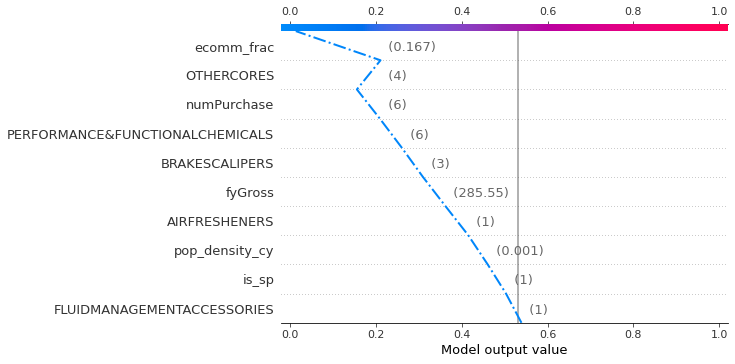

In [298]:
shap.decision_plot(expected_value, shap_values_XGB_test_yes[[j]], feature_names=yes_features, features=X_test_yes.iloc[j], feature_display_range=slice(-1, -11, -1),
                   link='logit', highlight=0)

### First we look at a couple of true positives

In [343]:
X_test_yes.mean()

fyGross                                                209.502
numPurchase                                              3.899
Recency                                                 96.322
daysSinceLastPurchase                                  144.633
isEmployee                                               0.006
numReturn                                                0.736
meanPurchaseTransaction                                 64.028
pop_est_cy                                          13,776.623
pop_density_cy                                           0.005
pct_white                                                0.148
age                                                     33.742
pct_college                                              0.135
pct_blue_collar                                          0.178
median_household_income                             54,415.016
establishments                                         445.825
IGNITIONEMISSIONFUELSYSTEMS                            

### Strong true postive

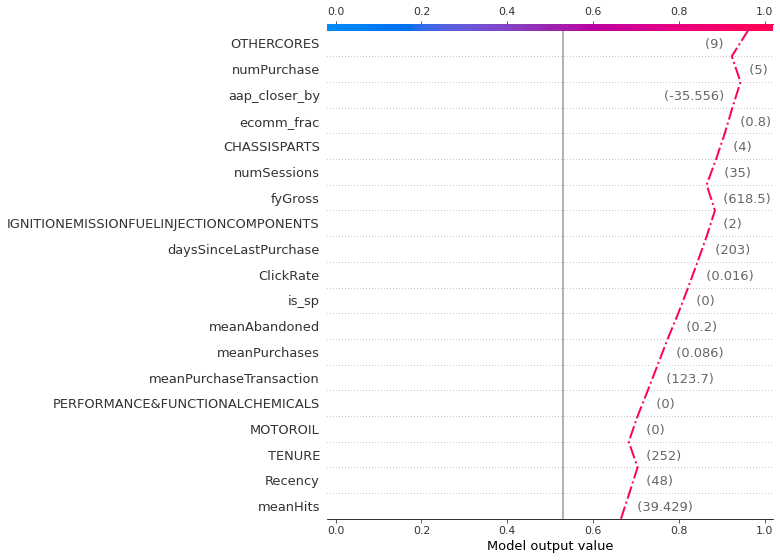

In [552]:
shap.decision_plot(expected_value, shap_values_XGB_test_yes[[[
       98971]]], feature_names=yes_features, features=X_test_yes.iloc[[
       98971]], feature_display_range=slice(-1, -20, -1),
                   link='logit', highlight=0)

### Difficult True Positive

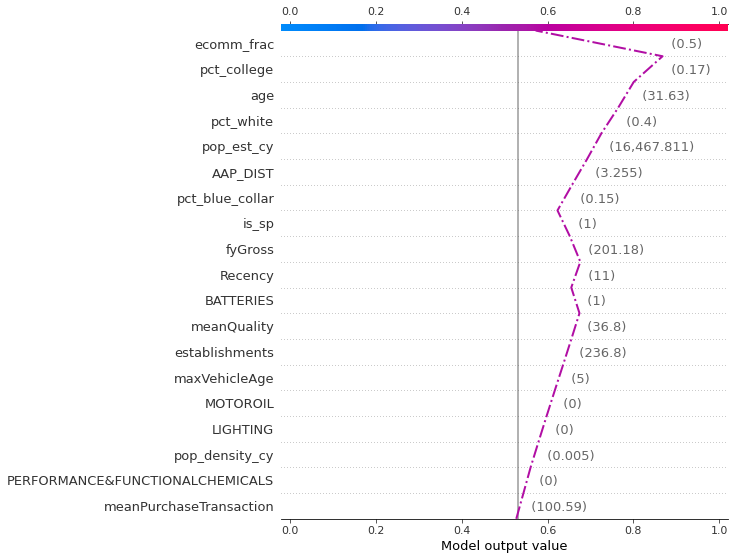

In [519]:
shap.decision_plot(expected_value, shap_values_XGB_test_yes[[[
       4218]]], feature_names=yes_features, features=X_test_yes.iloc[[
       4218]], feature_display_range=slice(-1, -20, -1),
                   link='logit', highlight=0)

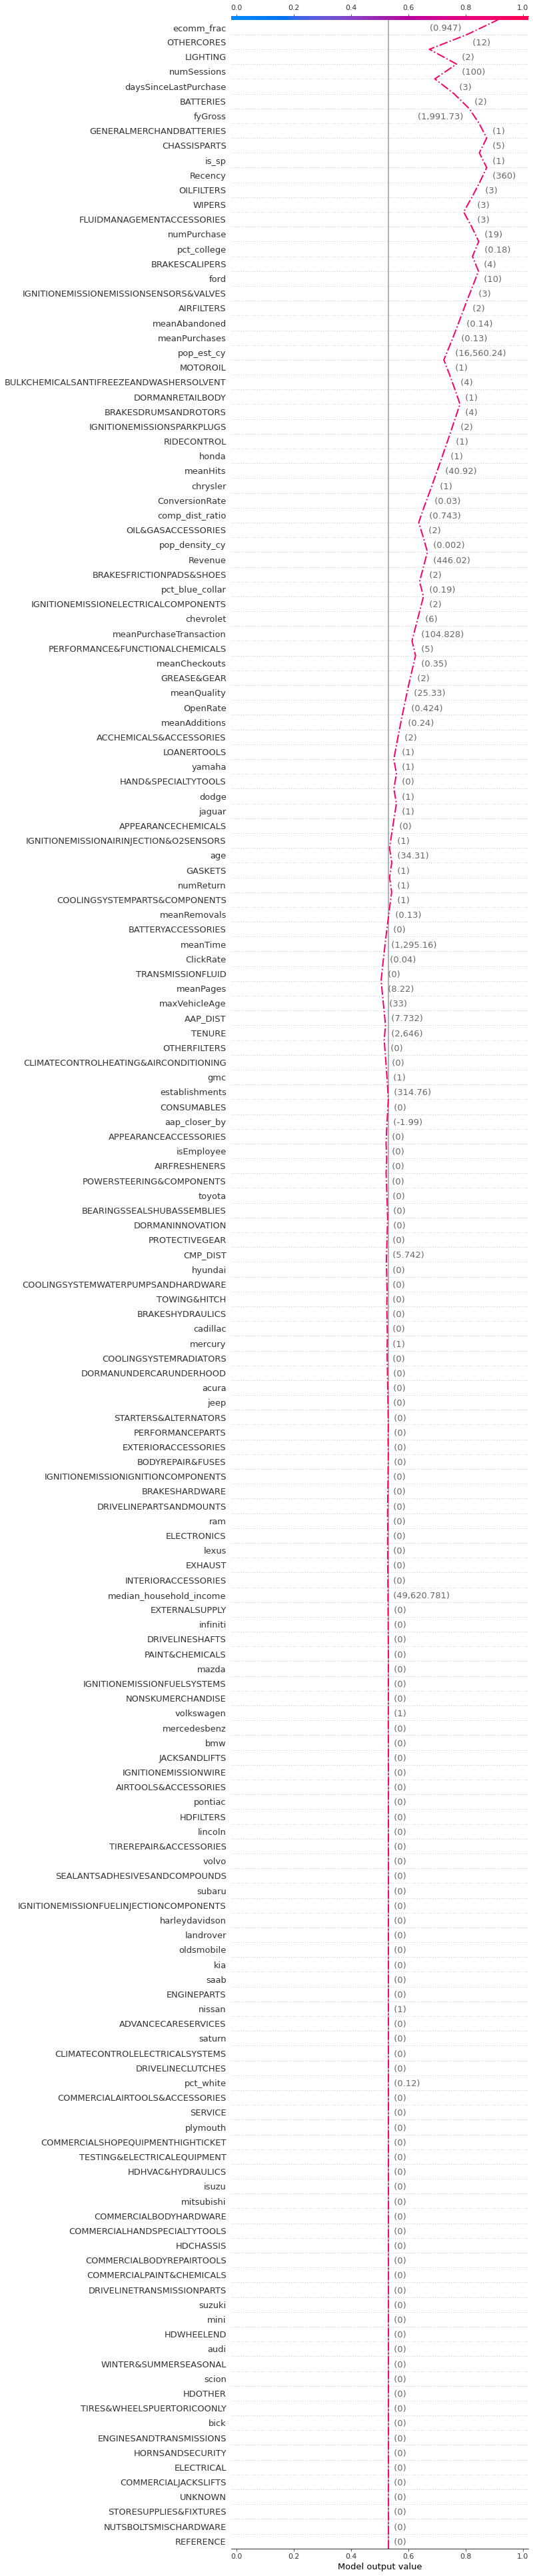

In [515]:
shap.decision_plot(expected_value, shap_values_XGB_test_yes[[[
       1996]]], feature_names=yes_features, features=X_test_yes.iloc[[
       1996]], feature_display_range=slice(-1, -200, -1),
                   link='logit', highlight=0)

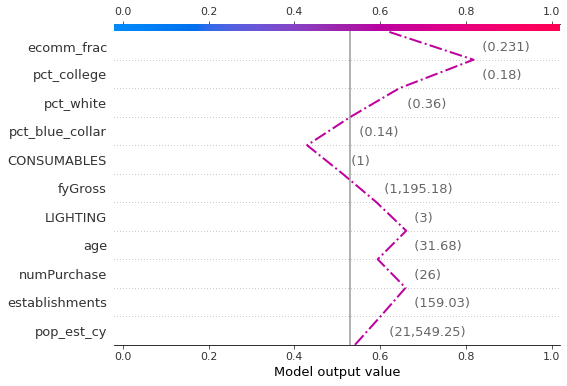

In [364]:
shap.decision_plot(expected_value, shap_values_XGB_test_yes[[[
       37214]]], feature_names=yes_features, features=X_test_yes.iloc[[
       37214]], feature_display_range=slice(-1, -12, -1),
                   link='logit', highlight=0)

In [586]:
mask = (false_negative_X_test_yes.ecomm_frac > 0.5) & (false_negative_X_test_yes.isEmployee == 0) & (false_negative_X_test_yes.numPurchase> 3 )# & (true_positive_X_test_yes.ecomm_frac < .99)

In [587]:
false_negative_indicies[0][mask]

array([     5,     19,     22, ..., 348683, 348719, 348850])

In [800]:
X_test_yes.iloc[122]

fyGross                                                590.740
numPurchase                                             14.000
Recency                                                326.000
daysSinceLastPurchase                                   29.000
isEmployee                                               0.000
numReturn                                                4.000
meanPurchaseTransaction                                 42.196
pop_est_cy                                          30,806.010
pop_density_cy                                           0.001
pct_white                                                0.110
age                                                     34.650
pct_college                                              0.130
pct_blue_collar                                          0.170
median_household_income                             77,995.656
establishments                                       1,324.710
IGNITIONEMISSIONFUELSYSTEMS                            

In [801]:
y_test_yes.iloc[122]

3quarter    1
Name: 10080086, dtype: int64

In [588]:
set(middling_indices[0]).intersection(set(false_negative_indicies[0][mask]))

{122,
 900,
 959,
 1233,
 1302,
 1409,
 1704,
 1784,
 2457,
 3039,
 3604,
 3832,
 4091,
 4360,
 4587,
 4960,
 5258,
 5440,
 5771,
 5883,
 6253,
 6630,
 6705,
 7090,
 7487,
 7894,
 9018,
 9377,
 9885,
 9890,
 10588,
 11064,
 11528,
 11702,
 12906,
 12936,
 13113,
 13740,
 15270,
 16141,
 16780,
 16875,
 17324,
 17804,
 17839,
 18021,
 18089,
 18154,
 18700,
 18829,
 18891,
 19401,
 20150,
 20312,
 20471,
 20717,
 20788,
 20964,
 20979,
 21342,
 21698,
 22013,
 22024,
 22045,
 22303,
 23279,
 24700,
 25118,
 25620,
 26483,
 26777,
 26818,
 26947,
 27004,
 27100,
 27127,
 27135,
 28779,
 29323,
 30124,
 30467,
 31126,
 31226,
 31797,
 32155,
 32169,
 33545,
 33849,
 34168,
 36277,
 36379,
 36699,
 37221,
 37784,
 37948,
 38478,
 39112,
 39232,
 39356,
 40863,
 41072,
 41079,
 42533,
 42891,
 43267,
 43819,
 44143,
 45063,
 46404,
 46745,
 46758,
 47454,
 47473,
 48571,
 48689,
 48798,
 49053,
 49147,
 49495,
 49749,
 50033,
 50279,
 50513,
 50570,
 50592,
 50843,
 51393,
 51932,
 52251,
 

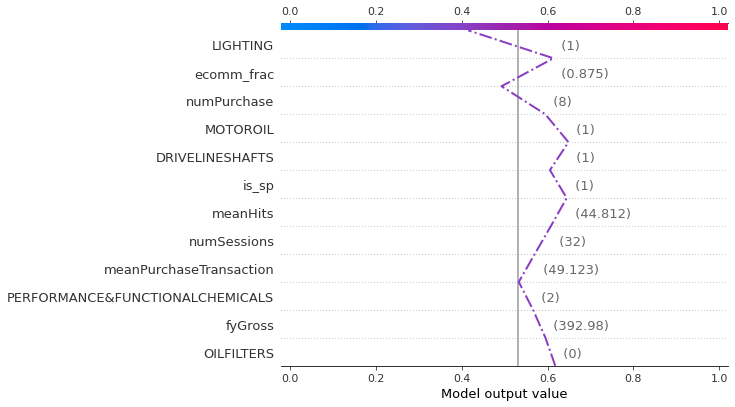

In [569]:
shap.decision_plot(expected_value, shap_values_XGB_test_yes[[[
       233474]]], feature_names=yes_features, features=X_test_yes.iloc[[
       233474]], feature_display_range=slice(-1, -13, -1),
                   link='logit', highlight=0)

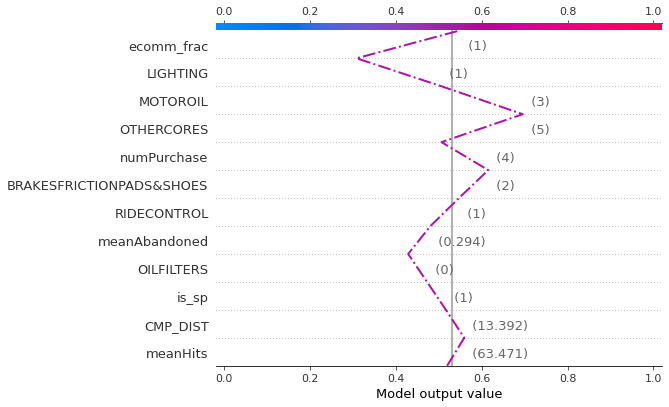

In [576]:
shap.decision_plot(expected_value, shap_values_XGB_test_yes[[[
       14]]], feature_names=yes_features, features=X_test_yes.iloc[[
       14]], feature_display_range=slice(-1, -13, -1),
                   link='logit', highlight=0)

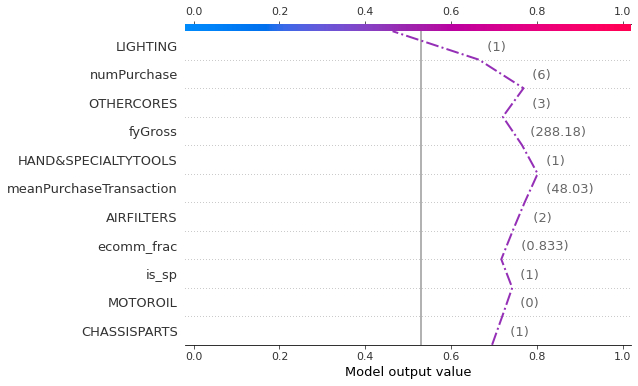

In [602]:
shap.decision_plot(expected_value, shap_values_XGB_test_yes[[[
       4091]]], feature_names=yes_features, features=X_test_yes.iloc[[
       4091]], feature_display_range=slice(-1, -12, -1),
                   link='logit', highlight=0)

### Beeswarm plot for true positives

In [542]:
explainerXGB_yes = shap.TreeExplainer(xg_class_yes)

In [543]:
shap_values_tp = explainerXGB_yes.shap_values(true_positive_X_test_yes)

In [544]:
shap_obj_tp = explainerXGB_yes(true_positive_X_test_yes)

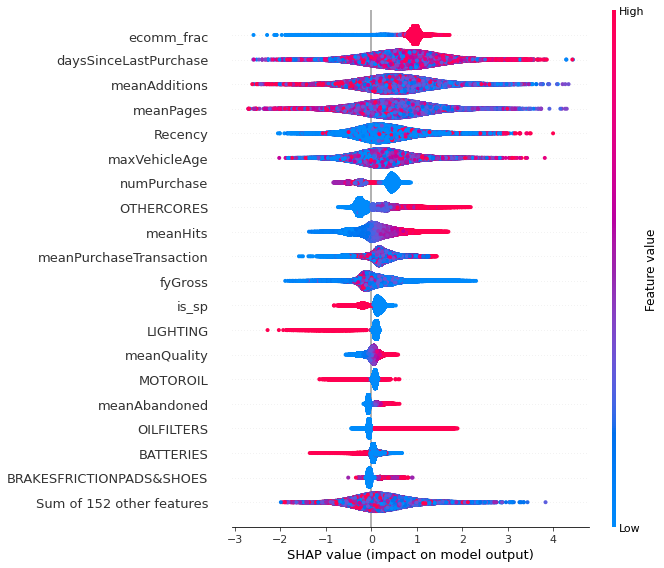

In [551]:
shap.plots.beeswarm(shap_obj_tp, max_display=20)

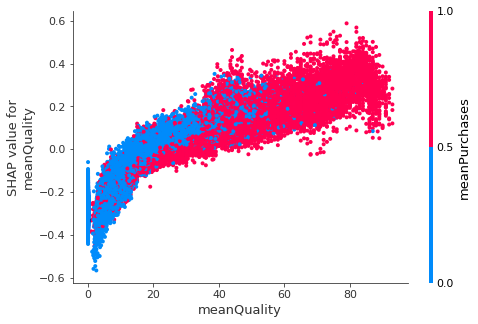

In [616]:
shap.dependence_plot('meanQuality', shap_values_tp, true_positive_X_test_yes)

### Beeswarm plot for true negatives

In [553]:
explainerXGB_yes = shap.TreeExplainer(xg_class_yes)

In [558]:
shap_values_tn = explainerXGB_yes.shap_values(true_negative_X_test_yes)

In [559]:
shap_obj_tn = explainerXGB_yes(true_negative_X_test_yes)

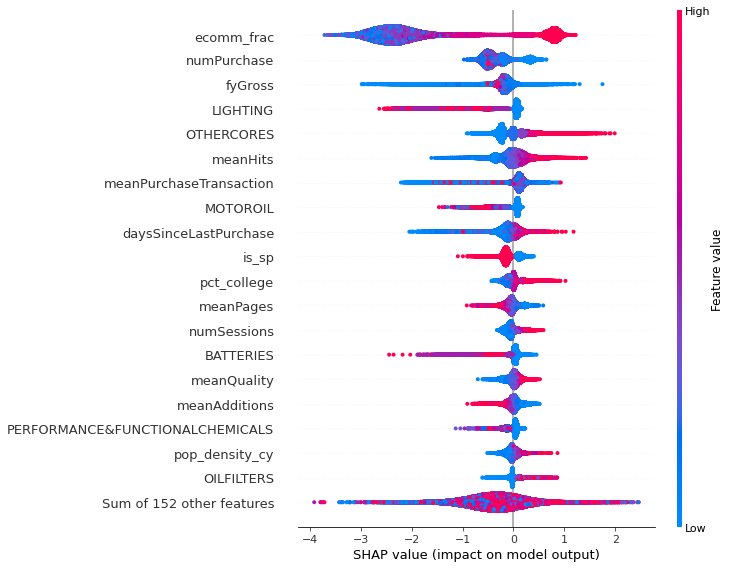

In [561]:
shap.plots.beeswarm(shap_obj_tn, max_display=20)

# Now we try SHAP for non-eCommerce engaged customers
### Due to the large size of the data, we only use a subset of the test data

In [808]:
_, X_test_no, _, y_test_no = train_test_split(X_test_no, y_test_no, 
                                                    test_size=0.2, random_state=1, stratify=y_test_no)

In [809]:
test_pred_no = xg_class_no.predict(X_test_no)

In [810]:
test_score_no = xg_class_no.predict_proba(X_test_no)

In [811]:
test_score_unpacked_no = [score[1] for score in test_score_no]

In [812]:
explainerXGB_no = shap.TreeExplainer(xg_class_no)

In [813]:
expected_value = explainerXGB_no.expected_value

In [814]:
len(X_test_no)

376711

In [815]:
shap_values_XGB_test_no = explainerXGB_no.shap_values(X_test_no)

In [816]:
np.array(y_test_no).squeeze().shape

(376711,)

In [817]:
test_pred_no.shape

(376711,)

In [818]:
len(test_score_unpacked_no)

376711

In [819]:
np.where(np.array(y_test_no).squeeze() != test_pred_no)[0]

array([    59,     86,    113, ..., 376671, 376707, 376710])

### We now collect lists of indexes for diffeerent catgories

In [820]:
true_positive_indicies = np.where((np.array(y_test_no).squeeze()==1) & (test_pred_no==1))

In [821]:
true_negative_indicies = np.where((np.array(y_test_no).squeeze()==0) & (test_pred_no==0))

In [822]:
false_positive_indicies = np.where((np.array(y_test_no).squeeze()==0) & (test_pred_no==1))

In [823]:
false_negative_indicies = np.where((np.array(y_test_no).squeeze()==1) & (test_pred_no==0))

In [824]:
len(true_positive_indicies[0]), len(true_negative_indicies[0]), len(false_positive_indicies[0]), len(false_negative_indicies[0])

(6680, 353006, 1414, 15611)

In [825]:
middling_indices = np.where((np.array(test_score_unpacked_no) < .6) & (np.array(test_score_unpacked_no) > .4))

In [826]:
high_indices = np.where((np.array(test_score_unpacked_no) < 1.0) & (np.array(test_score_unpacked_no) > .9))

In [827]:
low_indices = np.where((np.array(test_score_unpacked_no) < .4) & (np.array(test_score_unpacked_no) > 0.0))

In [828]:
true_positive_X_test_no = X_test_no_subset.iloc[list(true_positive_indicies[0])]

In [829]:
len(true_positive_X_test_no)

6680

In [830]:
true_negative_X_test_no = X_test_no_subset.iloc[list(true_negative_indicies[0])]

In [831]:
len(true_negative_X_test_no)

353006

In [832]:
false_positive_X_test_no = X_test_no_subset.iloc[list(false_positive_indicies[0])]

In [834]:
len(false_positive_X_test_no)

1414

In [833]:
false_negative_X_test_no = X_test_no_subset.iloc[list(false_negative_indicies[0])]

In [835]:
len(false_negative_X_test_no)

15611

In [836]:
np.array(test_score_unpacked_no_subset)[list(true_positive_indicies[0])].mean()

0.79373664

In [837]:
np.array(test_score_unpacked_no_subset)[list(false_positive_indicies[0])].mean()

0.63975567

In [838]:
np.array(test_score_unpacked_no_subset)[list(true_negative_indicies[0])].mean()

0.03877627

In [839]:
np.array(test_score_unpacked_no_subset)[list(false_negative_indicies[0])].mean()

0.15065376

In [840]:
np.array(test_score_unpacked_no_subset)[list(middling_indices[0])].mean()

0.48985296

### Beeswarm plot for true positives

In [663]:
shap_obj_tp = explainerXGB_no(true_positive_X_test_no)

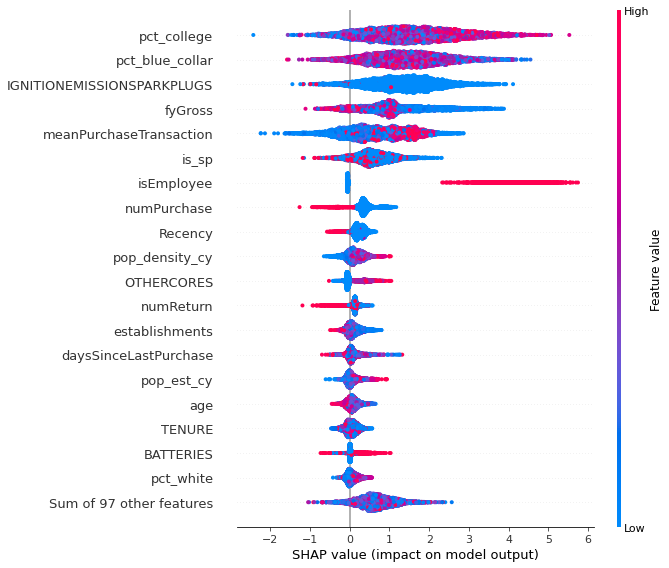

In [670]:
shap.plots.beeswarm(shap_obj_tp, max_display=20)

### Beeswarm plot for true negatives  - TBD

In [873]:
shap_obj_tn = explainerXGB_no(true_negative_X_test_no)

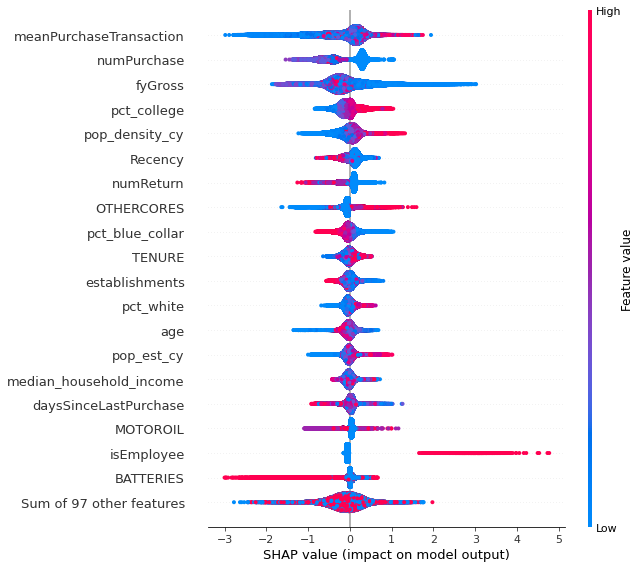

In [874]:
shap.plots.beeswarm(shap_obj_tn, max_display=20)

### Firm Positive

In [849]:
np.isin(true_positive_indicies[0], 131083).sum()

1

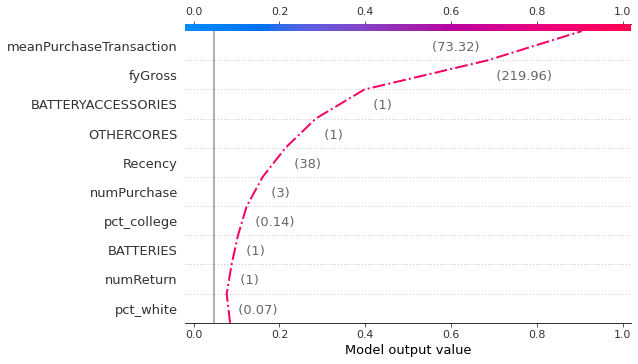

In [718]:
shap.decision_plot(expected_value, shap_values_XGB_test_no[131083], feature_names=no_features, features=X_test_no.iloc[131083], feature_display_range=slice(-1, -11, -1),
                   link='logit', highlight=0)

### Weak Positive

In [850]:
np.isin(true_positive_indicies[0], 223).sum()

1

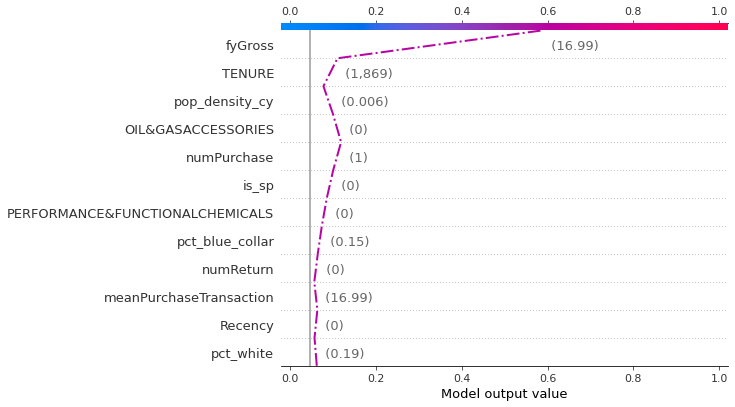

In [805]:
shap.decision_plot(expected_value, shap_values_XGB_test_no[[[
       223]]], feature_names=no_features, features=X_test_no.iloc[[
       223]], feature_display_range=slice(-1, -13, -1),
                   link='logit', highlight=0)

### Firm Negative

In [858]:
X_test_no.reset_index(inplace=True, drop=True)

In [860]:
indexes = X_test_no.index[(X_test_no.isEmployee == 0)  & (X_test_no.numPurchase > 20)].tolist()

In [862]:
len(indexes)

1825

In [867]:
set(low_indices[0]).intersection(set(true_negative_indicies[0]).intersection(set(indexes)))

{253958,
 286726,
 16395,
 270347,
 368676,
 40998,
 245808,
 73781,
 278583,
 81976,
 139326,
 245840,
 8291,
 16492,
 229484,
 139376,
 147576,
 295032,
 147582,
 90242,
 295048,
 139403,
 155795,
 196755,
 311445,
 123032,
 172184,
 254111,
 73894,
 237735,
 270504,
 311463,
 221356,
 254128,
 73907,
 114879,
 237761,
 368839,
 188616,
 8393,
 327885,
 106703,
 32979,
 98515,
 311508,
 352473,
 286942,
 123115,
 16632,
 131326,
 24834,
 82179,
 155910,
 254222,
 24847,
 205077,
 344352,
 319778,
 237880,
 147772,
 131389,
 115014,
 246093,
 155989,
 82264,
 24921,
 262489,
 287070,
 24927,
 213345,
 74086,
 213353,
 115068,
 205194,
 8591,
 262545,
 336273,
 319893,
 270743,
 295324,
 205219,
 237992,
 33195,
 246195,
 246206,
 205253,
 229830,
 147918,
 352726,
 254431,
 90593,
 16866,
 238051,
 246241,
 270820,
 279017,
 205303,
 172547,
 311811,
 369159,
 90632,
 246283,
 262668,
 16911,
 147988,
 311832,
 188968,
 180777,
 344620,
 98864,
 568,
 180793,
 16952,
 148025,
 25150,


In [864]:
X_test_no.iloc[253958]

fyGross                                              1,420.100
numPurchase                                             30.000
Recency                                                298.000
daysSinceLastPurchase                                   40.000
isEmployee                                               0.000
numReturn                                                4.000
meanPurchaseTransaction                                 47.337
pop_est_cy                                          16,554.961
pop_density_cy                                           0.005
pct_white                                                0.080
age                                                     36.400
pct_college                                              0.160
pct_blue_collar                                          0.170
median_household_income                             47,522.379
establishments                                         640.880
IGNITIONEMISSIONFUELSYSTEMS                            

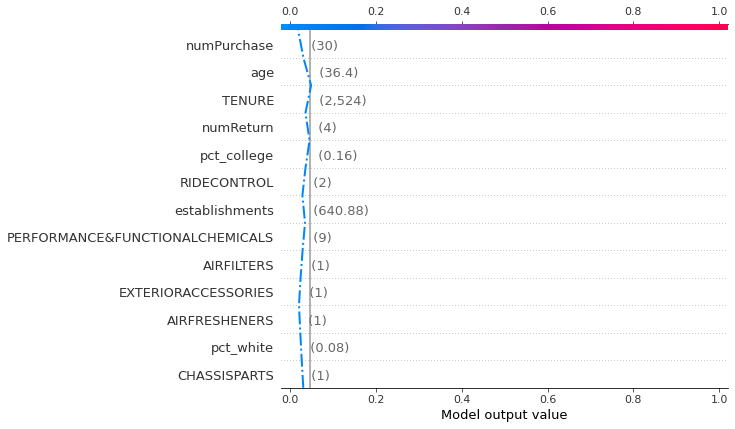

In [869]:
shap.decision_plot(expected_value, shap_values_XGB_test_no[[[
       253958]]], feature_names=no_features, features=X_test_no.iloc[[
       253958]], feature_display_range=slice(-1, -14, -1),
                   link='logit', highlight=0)

### Weak Negative

In [877]:
indexes = X_test_no.index[(X_test_no.isEmployee == 0)  & (X_test_no.numPurchase > 5)].tolist()

In [878]:
len(indexes)

32958

In [879]:
set(middling_indices[0]).intersection(set(true_negative_indicies[0]).intersection(set(indexes)))

{13020,
 13052,
 24661,
 26224,
 32876,
 42092,
 56747,
 57100,
 72137,
 88150,
 90911,
 91815,
 92776,
 96446,
 97434,
 131045,
 138552,
 157394,
 171466,
 211128,
 263418,
 270698,
 272600,
 273025,
 298051,
 307248,
 310080,
 326334,
 361234,
 364197}

In [880]:
X_test_no.iloc[13020]

fyGross                                                180.210
numPurchase                                              6.000
Recency                                                335.000
daysSinceLastPurchase                                   18.000
isEmployee                                               0.000
numReturn                                                0.000
meanPurchaseTransaction                                 30.035
pop_est_cy                                          15,670.230
pop_density_cy                                           0.004
pct_white                                                0.230
age                                                     30.020
pct_college                                              0.170
pct_blue_collar                                          0.160
median_household_income                             51,498.250
establishments                                         274.310
IGNITIONEMISSIONFUELSYSTEMS                            

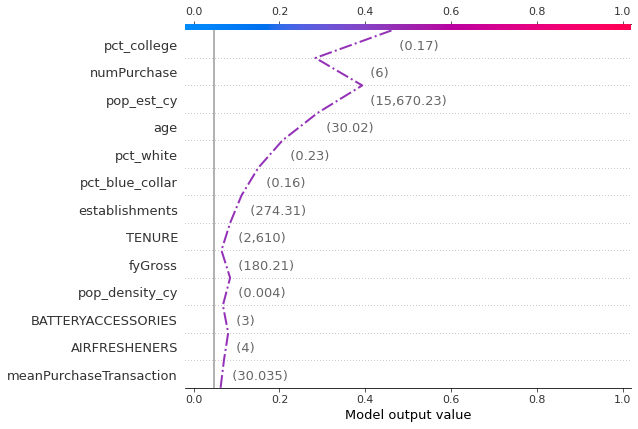

In [881]:
shap.decision_plot(expected_value, shap_values_XGB_test_no[[[
       13020]]], feature_names=no_features, features=X_test_no.iloc[[
       13020]], feature_display_range=slice(-1, -14, -1),
                   link='logit', highlight=0)

### False Positive

In [882]:
indexes = X_test_no.index[(X_test_no.isEmployee == 0)  & (X_test_no.numPurchase > 3)].tolist()

In [883]:
len(indexes)

66457

In [885]:
set(middling_indices[0]).intersection(set(false_positive_indicies[0]).intersection(set(indexes)))

{7182,
 13883,
 17323,
 18149,
 27120,
 29738,
 47737,
 49568,
 63874,
 72451,
 92048,
 94129,
 132560,
 166513,
 169696,
 184521,
 198826,
 209882,
 216761,
 217507,
 218746,
 238112,
 250200,
 258235,
 261373,
 271466,
 290449,
 293893,
 305806,
 312624,
 327139,
 330472,
 338156,
 341355}

In [886]:
X_test_no.iloc[7182]

fyGross                                                 56.530
numPurchase                                              5.000
Recency                                                181.000
daysSinceLastPurchase                                   41.000
isEmployee                                               0.000
numReturn                                                0.000
meanPurchaseTransaction                                 11.306
pop_est_cy                                          14,739.950
pop_density_cy                                           0.005
pct_white                                                0.160
age                                                     32.690
pct_college                                              0.170
pct_blue_collar                                          0.150
median_household_income                             52,418.121
establishments                                         185.970
IGNITIONEMISSIONFUELSYSTEMS                            

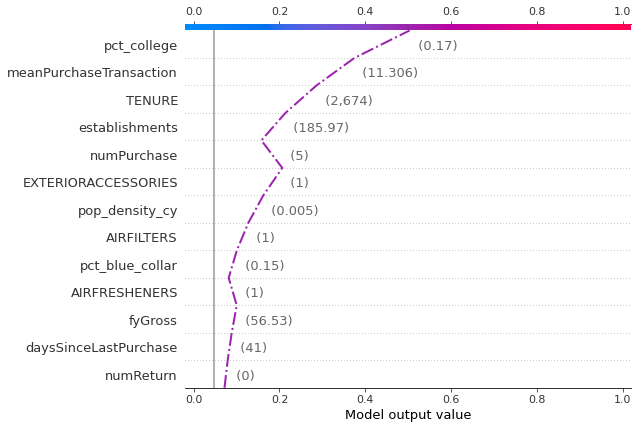

In [887]:
shap.decision_plot(expected_value, shap_values_XGB_test_no[[[
       7182]]], feature_names=no_features, features=X_test_no.iloc[[
       7182]], feature_display_range=slice(-1, -14, -1),
                   link='logit', highlight=0)

### False Negative

In [888]:
indexes = X_test_no.index[(X_test_no.isEmployee == 0)  & (X_test_no.numPurchase > 3)].tolist()

In [889]:
len(indexes)

66457

In [891]:
set(middling_indices[0]).intersection(set(false_negative_indicies[0]).intersection(set(indexes)))

{8531,
 19500,
 24723,
 32843,
 49179,
 57253,
 57844,
 58805,
 87959,
 113011,
 113530,
 124431,
 134259,
 158661,
 159611,
 174784,
 175509,
 207037,
 212916,
 219503,
 237381,
 256572,
 277211,
 279922,
 280232,
 284563,
 311557,
 314266,
 329833,
 333937,
 357109,
 359559,
 375769}

In [892]:
X_test_no.iloc[8531]

fyGross                                              1,281.370
numPurchase                                             25.000
Recency                                                361.000
daysSinceLastPurchase                                    2.000
isEmployee                                               0.000
numReturn                                                4.000
meanPurchaseTransaction                                 51.255
pop_est_cy                                          18,324.350
pop_density_cy                                           0.004
pct_white                                                0.250
age                                                     31.540
pct_college                                              0.160
pct_blue_collar                                          0.170
median_household_income                             46,039.898
establishments                                         261.380
IGNITIONEMISSIONFUELSYSTEMS                            

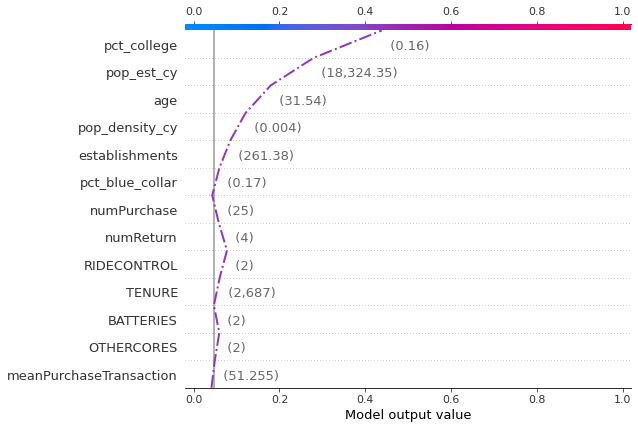

In [893]:
shap.decision_plot(expected_value, shap_values_XGB_test_no[[[
       8531]]], feature_names=no_features, features=X_test_no.iloc[[
       8531]], feature_display_range=slice(-1, -14, -1),
                   link='logit', highlight=0)